In [1]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from lib.funcs import *
from lib.mapping import *

In [2]:
recorte_maior = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_maior.shp')
recorte_menor = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_menor.shp')
limite_mun = gpd.read_file('./data/BASES/limite_municipio/limite_municipio.shp')
lotes_empreendimentos = gpd.read_file('./data/BASES/empreendimento/empreendimento.shp')
populacao_bairros = gpd.read_file('./data/POPULACAO/bairros.shp')
populacao_setores = gpd.read_file('./data/POPULACAO/setores_recorte.shp')
limite_mun = gpd.read_file("./data/BASES/limite_municipio/limite_municipio.shp")
bairros_recorte_menor = gpf.read_file("./data/BASES/bairros/bairros_")

lotes_empreendimentos = lotes_empreendimentos.to_crs(epsg=3857)

In [3]:
lotes_empreendimentos = lotes_empreendimentos.reindex([1, 0, 2])
lotes_empreendimentos['Name'] = lotes_empreendimentos.index+1
lotes_empreendimentos['coords'] = lotes_empreendimentos['geometry'].apply(lambda x: x.centroid.coords[:])
lotes_empreendimentos['coords'] = [coords[0] for coords in lotes_empreendimentos['coords']]

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f30077a6a40> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


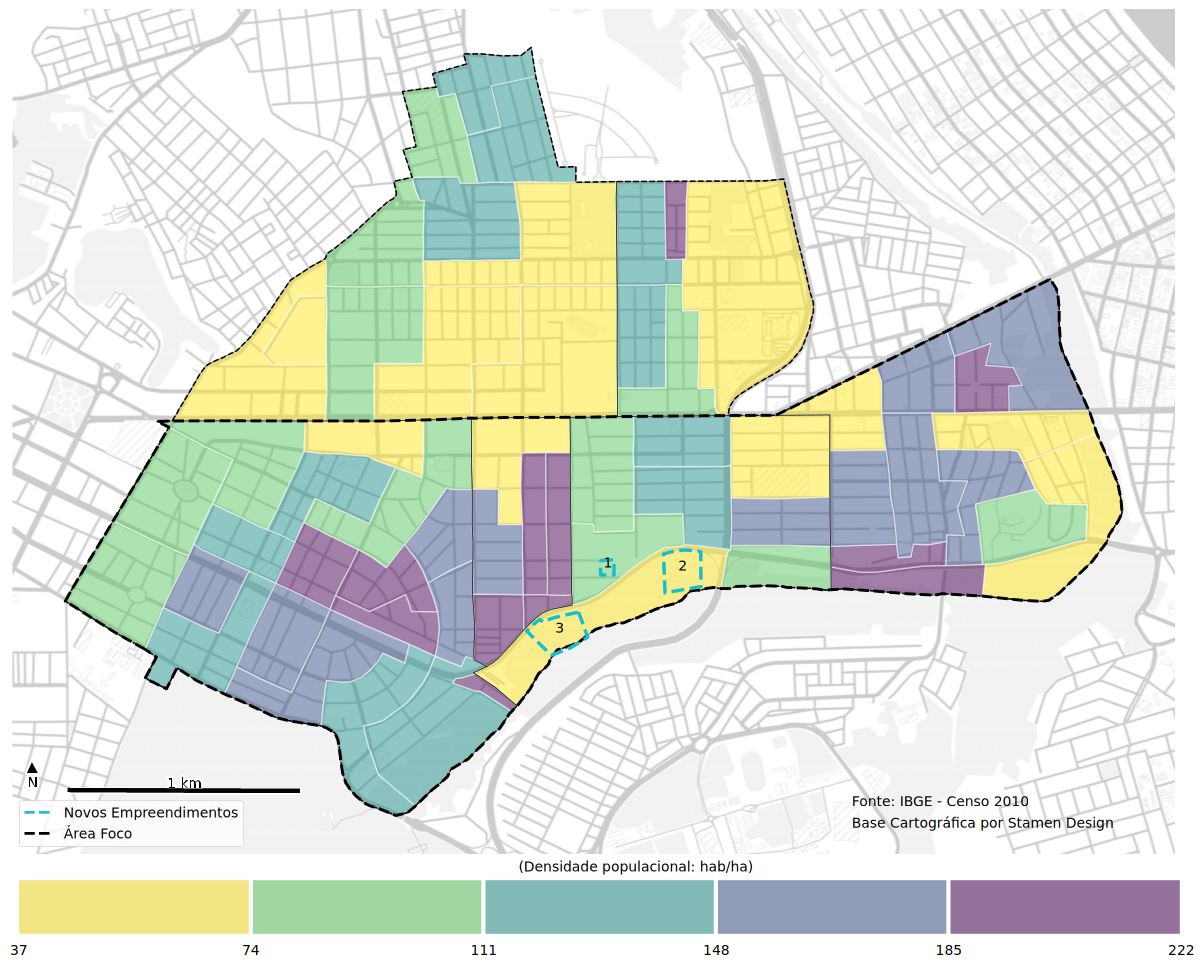

In [4]:
borders = [recorte_maior, recorte_menor]
plot_categorical(populacao_setores, 
                 'densidade',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor], 
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .83,
                 .79,
                 'densidade_populacional_recorte', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 16, 
                 '(Densidade populacional: hab/ha)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1,
                 annotate_bairros=False)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2fff4ddae0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


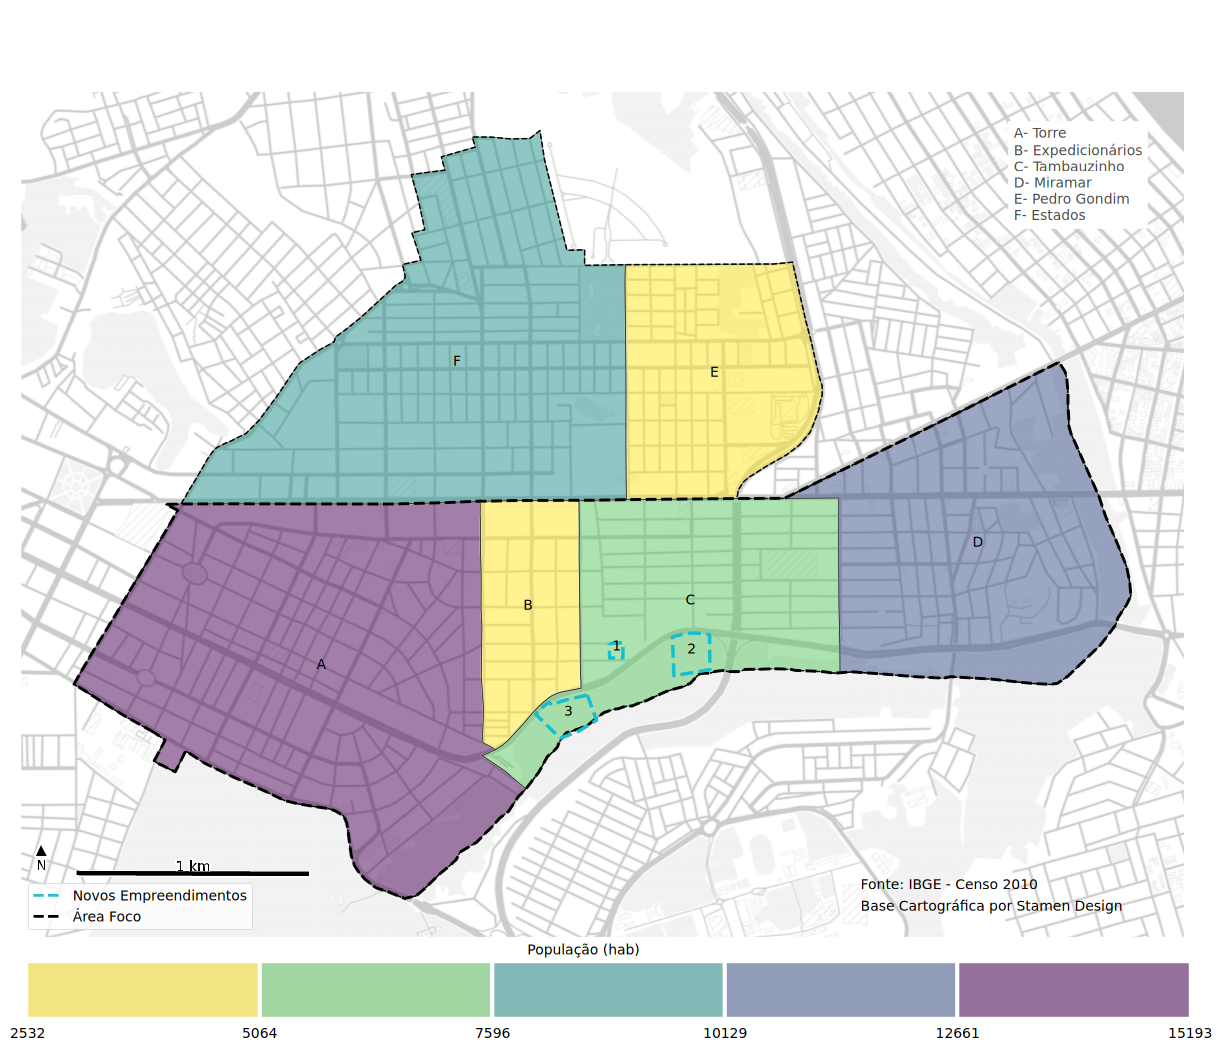

In [5]:
plot_categorical(bairros_recorte_maior, 
                 'MORADORES',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .83,
                 .79,
                 'populacao_recorte', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 16, 
                 'População (hab)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2ffec62e00> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


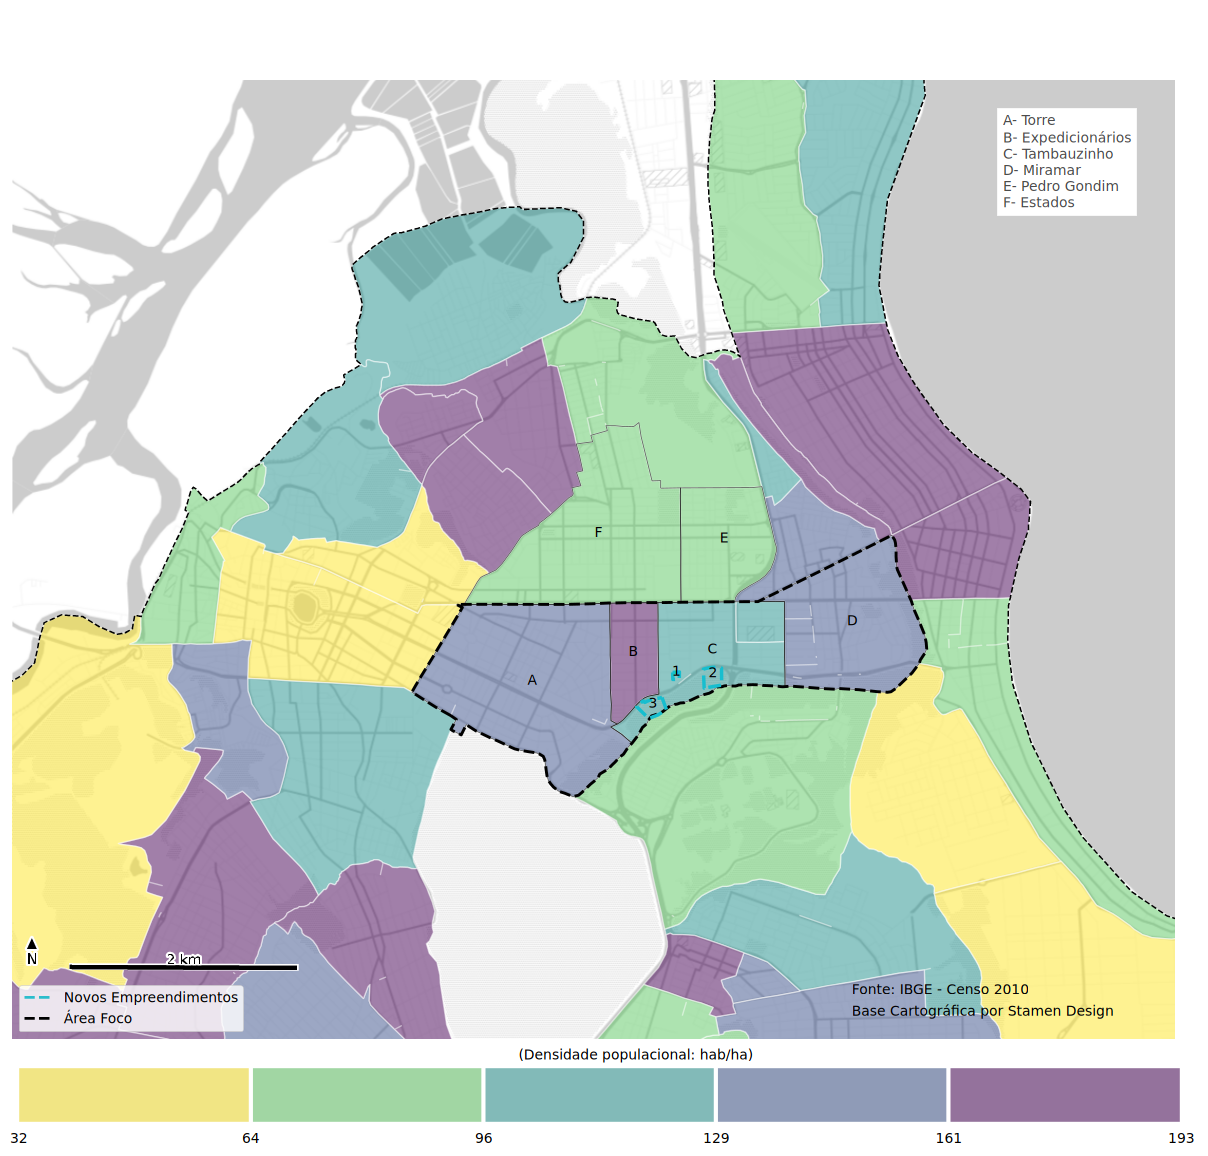

In [6]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor], 
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .83,
                 .82,
                 'densidade_populacional_centro', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 14, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f30163e0cc0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


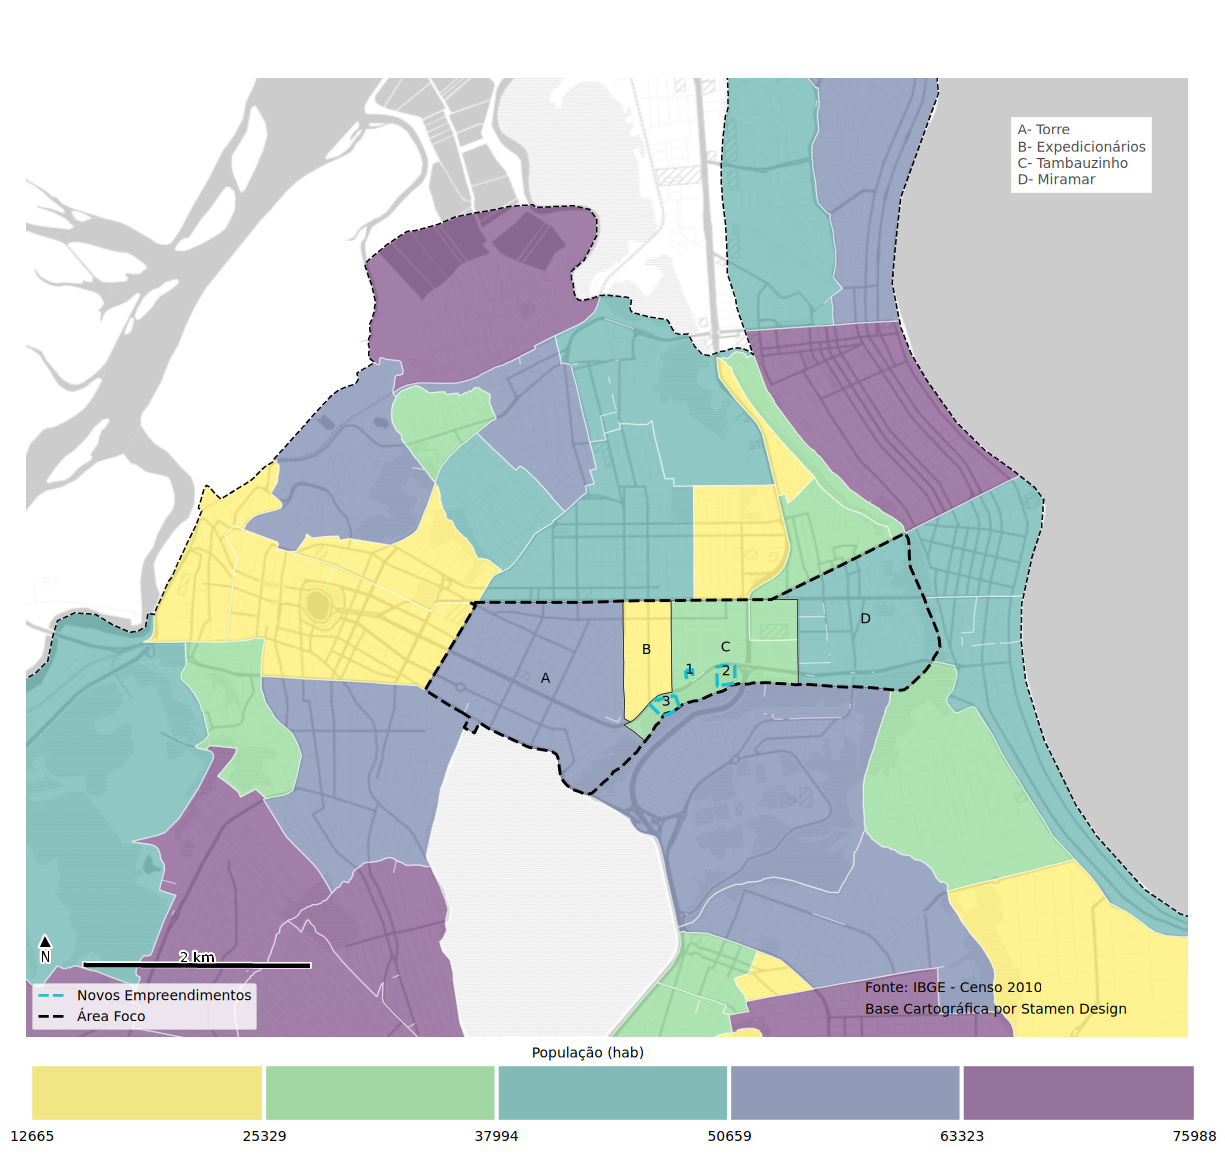

In [7]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .84,
                 'populacao_centro', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 14, 
                 'População (hab)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2ffec90a40> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


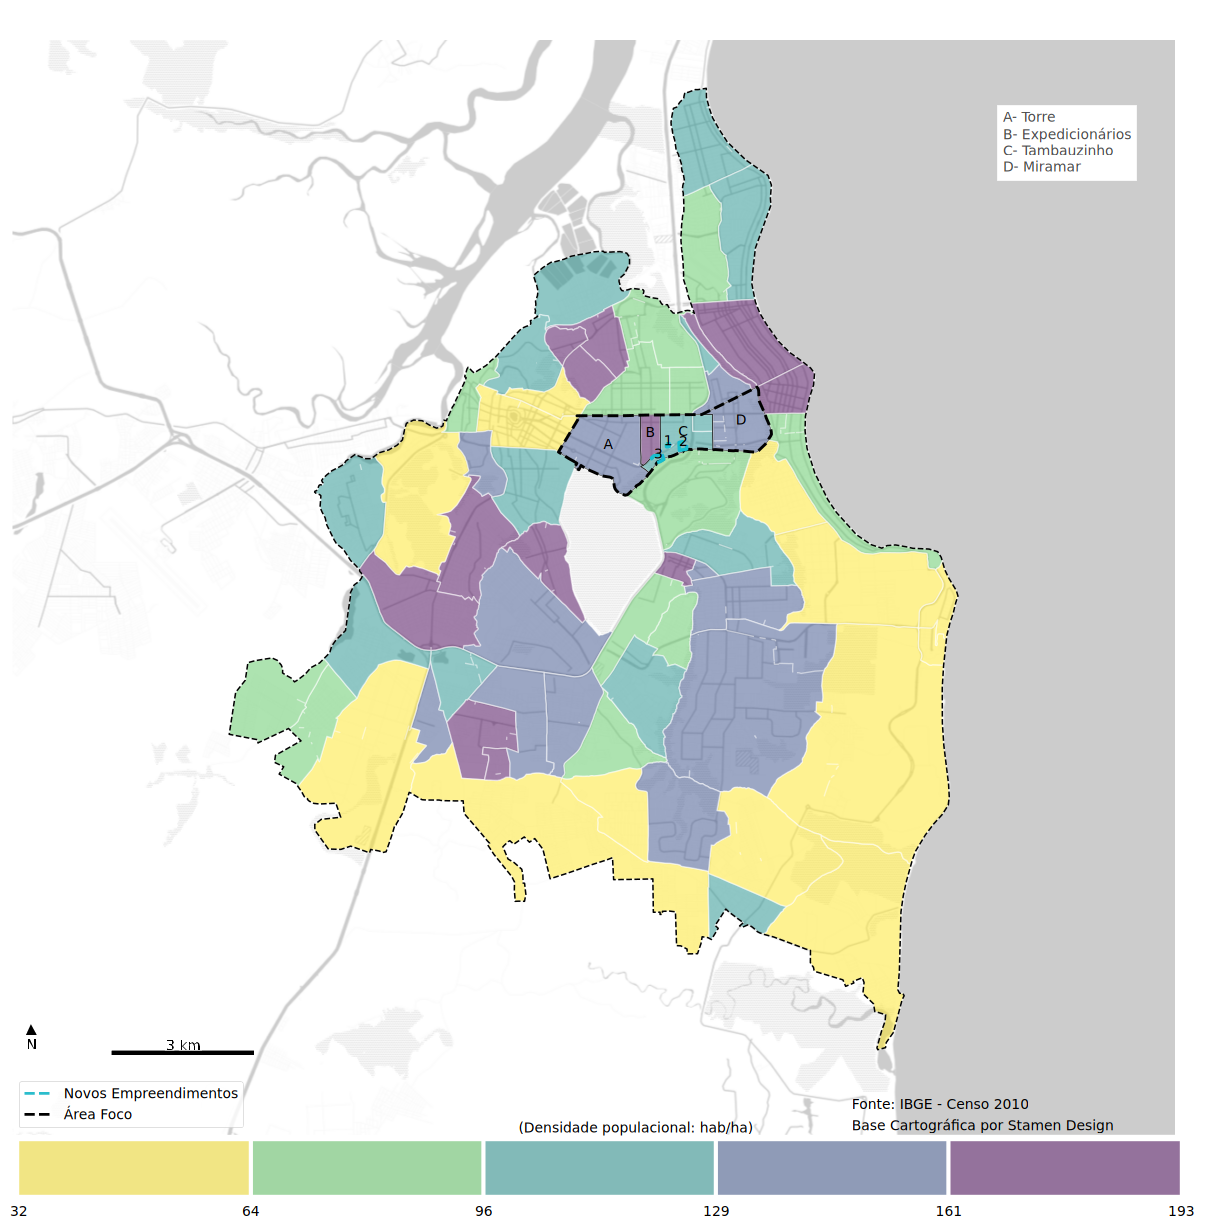

In [8]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .86,
                 'densidade_populacional_cidade', 
                 (600, 65), 
                 (600, 50), 
                 (360, 48),
                 13, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=3,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1.07,
                 factor_top=1)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2fff50f130> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


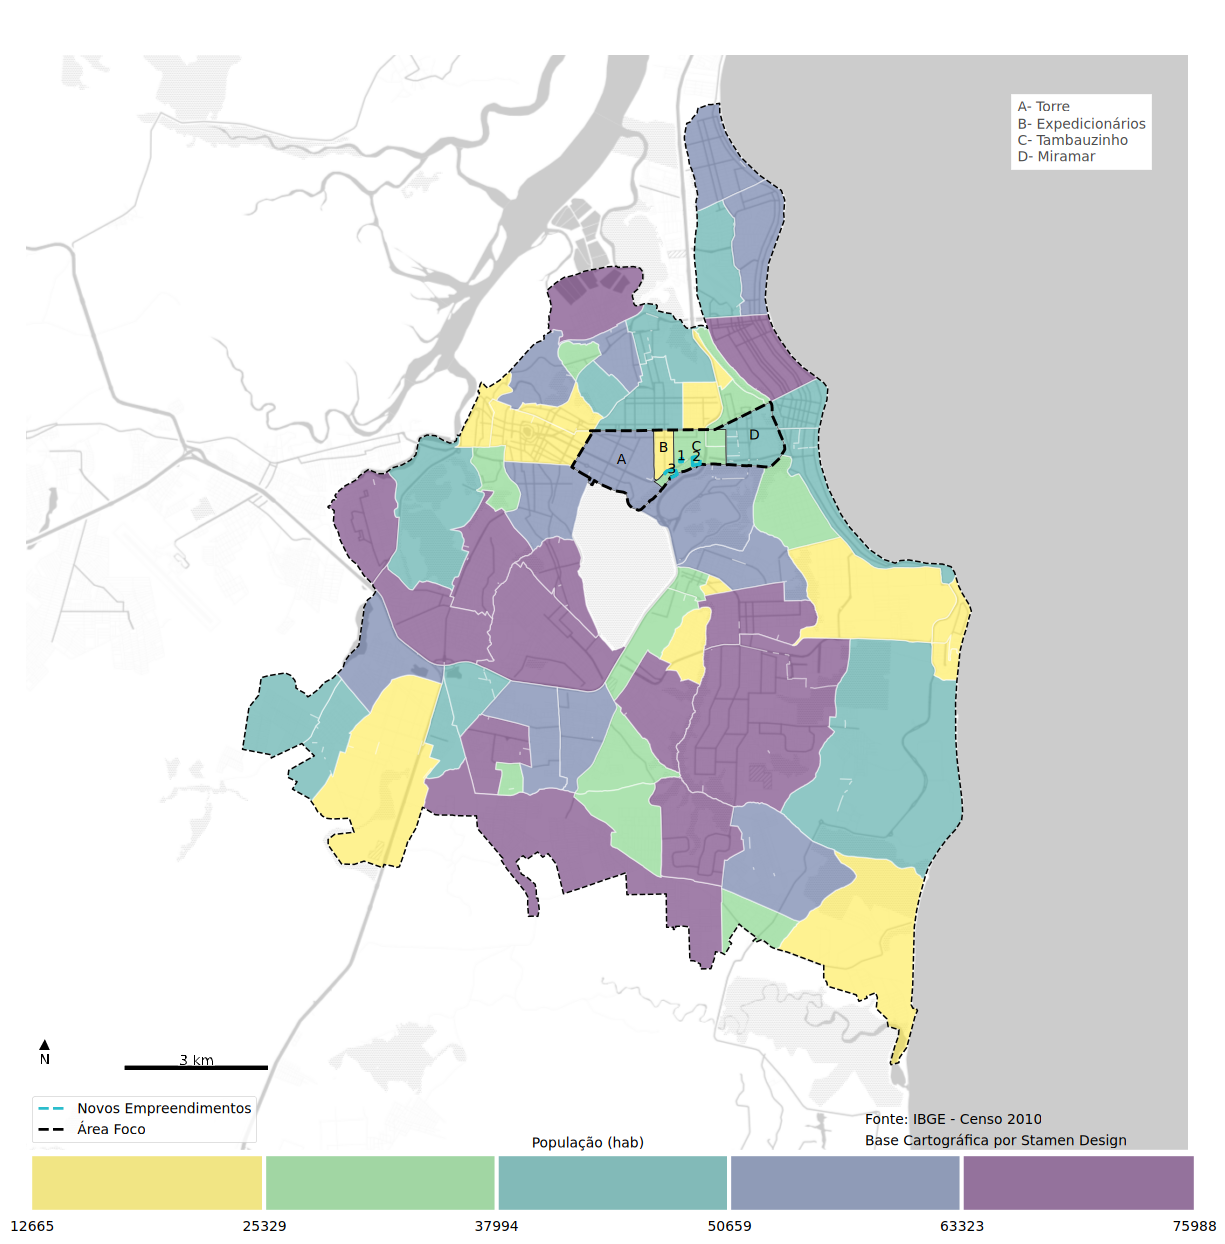

In [9]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .87,
                 'populacao_cidade', 
                 (600, 65), 
                 (600, 50), 
                 (360, 48),
                 13, 
                 'População (hab)', 
                 scale_extension=3,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1.07,
                 factor_top=1)